# 參考網站 
+ [微軟的範例](https://github.com/microsoft/ML-For-Beginners/tree/main/7-TimeSeries/2-ARIMA)
+ [ARIMA-GARCH 模型(上)](https://medium.com/tej-api-%E9%87%91%E8%9E%8D%E8%B3%87%E6%96%99%E5%88%86%E6%9E%90/%E8%B3%87%E6%96%99%E7%A7%91%E5%AD%B8-%E5%8D%81-arima-garch%E6%A8%A1%E5%9E%8B-%E4%B8%8A-4cf07dac75fd)

# 參考網站 
+ [微軟的範例](https://github.com/microsoft/ML-For-Beginners/tree/main/7-TimeSeries/2-ARIMA)
+ [ARIMA-GARCH 模型(上)](https://medium.com/tej-api-%E9%87%91%E8%9E%8D%E8%B3%87%E6%96%99%E5%88%86%E6%9E%90/%E8%B3%87%E6%96%99%E7%A7%91%E5%AD%B8-%E5%8D%81-arima-garch%E6%A8%A1%E5%9E%8B-%E4%B8%8A-4cf07dac75fd)

# 參數設定

In [1]:
HORIZON = 1 # 0: 預設當日、1: 預測隔日(原本深度學習)，程式寫法僅支援 0,1

predict_types = [3]
fieldName = 'GroupCount'

# predict_types = [1]
# fieldName = 'GroupCount'

# training_window = @training_window@ # 過去天數，用於訓練資料中的歷史資料長度
# predict_type = @predict_type@
# fieldName = '@label_column@' 

# ==== 底下的參數基本上都不要亂動 ====
training_window = 14  # 過去天數，用於訓練資料中的歷史資料長度 
train_split_rate = 0.04  # 訓練集佔整體資料集的比例
# includeTraingData = False  # 資料來源是否包含訓練集最後 14 天，正常要包含，但有少數一些資料會有問題，若遇到有問題，把這個改成 False
 

actFiledName = fieldName 
if HORIZON == 1:
    actFiledName = f'{actFiledName}1'
    
model_dir = 'ARIMA/_Model'

# 定義類別

In [2]:
# 重新載入 Lib，讓檔案可以直接修改使用 
import importlib
import ArimaLib 
importlib.reload(ArimaLib)   

from ArimaLib import * 
arima = ArimaLib()

import sys
print(sys.prefix)

/Users/elliesu/Developer/nckuenv


# 清除舊的訓練資料

In [3]:
result_file_name = arima.reset_data(
    model_dir, 
    label_name = fieldName, 
    predicteds = predict_types
)

result_file_name: ARIMA/_Model/GroupCount_data3.result.json


# 載入數據

In [4]:
arima_data = arima.load_data(predict_types)[[fieldName]]
arima_data

# 載入數據


,GroupCount
RequestTime,
2023-04-02,12172
2023-04-03,14427
2023-04-04,13731
2023-04-05,17825
2023-04-06,41521
...,...
2024-04-26,32929
2024-04-27,22126
2024-04-28,19550


# 切割訓練和測試資料集

In [5]:
train_data, test_data = arima.split_train_test_data(arima_data, train_split_rate)
# train_data, test_data = arima.split_train_test_data2(arima_data, training_window=training_window)

# 切割訓練和測試資料集，split rate 0.04
這裡切割訓練和測試跟深度學習不同，這裡只是單純的要切割測試資料集區間，實際上並沒有用到訓練集
data length: 395
train_data.shape: (15, 1)
test_data.shape: (380, 1)


# 原始資料視覺化

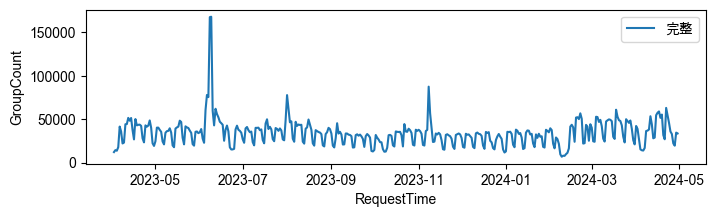

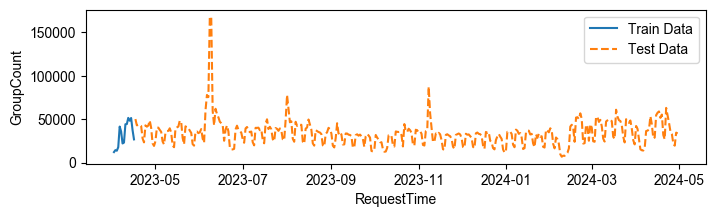

In [6]:
plt.figure(figsize=(8, 2))
plt.plot(arima_data.index, arima_data[fieldName], label='完整')

plt.xlabel('RequestTime')
plt.ylabel(fieldName)
plt.legend()
plt.show()

plt.figure(figsize=(8, 2))
plt.plot(train_data.index, train_data[fieldName], label='Train Data')
plt.plot(test_data.index, test_data[fieldName], label='Test Data', linestyle='--')

plt.xlabel('RequestTime')
plt.ylabel(fieldName)
plt.legend()
plt.show()

# 找出最佳參數

In [7]:
# if includeTraingData:
#     print(f'使用訓練集前 {training_window} 天')
#     aic_data = [x for x in train_data[fieldName]]
#     aic_data = aic_data[(-training_window):] 
#     aic_data.extend(test_data[fieldName].values) 
# else:
#     print(f'不使用訓練集前 {training_window} 天')
#     aic_data = test_data[fieldName].values

aic_data = arima_data[fieldName].values
print(len(aic_data))

auto_model, best_p, best_d, best_q, best_aic, arima_resid, best_ar_pvalue, best_ma_pvalue = \
    arima.find_best_config(aic_data, window_size=training_window)
# 基本上選出來的 P-Vaule 都要小於 0.05，才達到顯著的效果，代表是平穩的序列

395
# 找到最佳的 p, d, q 值，window_size: 14 



Best model:  ARIMA(10,0,10)(0,0,0)[0]          
Total fit time: 32.907 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  395
Model:             SARIMAX(10, 0, 10)   Log Likelihood               -4173.763
Date:                Thu, 19 Jun 2025   AIC                           8389.526
Time:                        11:01:03   BIC                           8473.083
Sample:                             0   HQIC                          8422.632
                                - 395                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0438      0.754     -0.058      0.954      -1.522       1.435
ar.L2          0.0891      0.551      0.162      0.

# 使用 ARMIA 套件再次驗證

In [8]:
model_summary_fit = arima.check_arima_model(aic_data, best_p, best_d, best_q)

# 檢查 ARIMA 模型


/Users/elliesu/Developer/nckuenv/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  395
Model:               ARIMA(10, 0, 10)   Log Likelihood               -4169.932
Date:                Thu, 19 Jun 2025   AIC                           8383.863
Time:                        11:01:04   BIC                           8471.399
Sample:                             0   HQIC                          8418.545
                                - 395                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.403e+04   2538.380     13.406      0.000    2.91e+04     3.9e+04
ar.L1          0.2304      0.700      0.329      0.742      -1.141       1.602
ar.L2          0.5195      0.968      0.536      0.5

# Shift 預測資料

In [9]:
test_shifted = arima.shift_data(test_data, fieldName, HORIZON)
test_shifted.head()
print(len(test_shifted))

# 整理預測未來的資料
380


# 執行預測

In [10]:
test_ts, predictions = arima.predict(
    train_data, test_shifted, 
    field_name=fieldName, 
    act_field_name=actFiledName,
    best_d=best_d,
    best_p=best_p,
    best_q=best_q,
    training_window=training_window,
    horizon=HORIZON
)

# 開始預測
第一個預測日 :  2023-04-17 00:00:00
第一個預測日，前 {training_window} 日數據 :               GroupCount
RequestTime            
2023-04-03        14427
2023-04-04        13731
2023-04-05        17825
2023-04-06        41521
2023-04-07        35866
2023-04-08        22108
2023-04-09        23114
2023-04-10        44226
2023-04-11        44386
2023-04-12        51507
2023-04-13        48272
2023-04-14        51376
2023-04-15        37490
2023-04-16        26776
第一個預測日當日 :  50143.0
第一個預測日隔日 :  42924.0
第一個預測日，前 {training_window} 日數據 :  [12172, 14427, 13731, 17825, 41521, 35866, 22108, 23114, 44226, 44386, 51507, 48272, 51376, 37490, 26776]
最佳的 p 值: 10
最佳的 d 值: 0
最佳的 q 值: 10
-------------------------------------------------------
-------------------------------------------------------

yhat: [28403.4994804  36916.19864593]
( 0). 實際 : 42924.0 預測 : 36916.19864592755 差距 : 6007.80135407245


/Users/elliesu/Developer/nckuenv/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


yhat: [52422.53091189 37148.64103932]
( 1). 實際 : 43556.0 預測 : 37148.64103932295 差距 : 6407.358960677047
yhat: [35615.47576502 28997.21738798]
( 2). 實際 : 43756.0 預測 : 28997.21738798495 差距 : 14758.78261201505


yhat: [31048.86885071 31237.49409726]
( 3). 實際 : 42312.0 預測 : 31237.494097257888 差距 : 11074.505902742112
yhat: [28774.48915338 47257.11928377]
( 4). 實際 : 27920.0 預測 : 47257.119283772656 差距 : -19337.119283772656


yhat: [52154.34814697 22107.46663113]
( 5). 實際 : 23347.0 預測 : 22107.466631132163 差距 : 1239.5333688678365
yhat: [25904.43741412 42793.41735194]
( 6). 實際 : 42904.0 預測 : 42793.41735193655 差距 : 110.5826480634496


yhat: [32411.07181215 52323.46425934]
( 7). 實際 : 41392.0 預測 : 52323.464259338485 差距 : -10931.464259338485
yhat: [36948.28271069 34416.58729959]
( 8). 實際 : 42693.0 預測 : 34416.58729958944 差距 : 8276.412700410561


yhat: [33630.7855997  40083.51775767]
( 9). 實際 : 48575.0 預測 : 40083.517757671754 差距 : 8491.482242328246
yhat: [41465.95959645 39610.62211396]
(10). 實際 : 40120.0 預測 : 39610.622113959376 差距 : 509.3778860406237


yhat: [41199.31968124 23070.01013597]
(11). 實際 : 22265.0 預測 : 23070.01013597111 差距 : -805.0101359711116
yhat: [22752.90446178 21858.87010439]
(12). 實際 : 19269.0 預測 : 21858.87010439135 差距 : -2589.8701043913497


yhat: [22001.23165543 37048.18203853]
(13). 實際 : 24632.0 預測 : 37048.18203852688 差距 : -12416.18203852688
yhat: [36685.22134821 39928.90800664]
(14). 實際 : 40302.0 預測 : 39928.908006640675 差距 : 373.091993359325


yhat: [42255.62893758 50822.50216013]
(15). 實際 : 40291.0 預測 : 50822.50216013192 差距 : -10531.502160131917
yhat: [51225.65647172 52439.27693557]
(16). 實際 : 37709.0 預測 : 52439.27693556853 差距 : -14730.27693556853


yhat: [59497.23580522 45791.21592305]
(17). 實際 : 35487.0 預測 : 45791.21592305487 差距 : -10304.215923054871
yhat: [44807.83368741 10120.52318069]
(18). 實際 : 24306.0 預測 : 10120.523180686469 差距 : 14185.476819313531


yhat: [ 6757.72385577 -8269.18187997]
(19). 實際 : 21035.0 預測 : -8269.181879973272 差距 : 29304.181879973272
yhat: [ 3919.23483892 18219.76928416]
(20). 實際 : 34405.0 預測 : 18219.769284155293 差距 : 16185.230715844707


yhat: [24582.02496315 33512.43568434]
(21). 實際 : 36245.0 預測 : 33512.43568433508 差距 : 2732.5643156649166
yhat: [44870.56849514 42747.78083451]
(22). 實際 : 36565.0 預測 : 42747.78083450752 差距 : -6182.780834507517


yhat: [39972.60971482 41113.0247328 ]
(23). 實際 : 39546.0 預測 : 41113.02473280209 差距 : -1567.0247328020923
yhat: [43335.18393255 36868.0541013 ]
(24). 實際 : 34654.0 預測 : 36868.0541012989 差距 : -2214.054101298898


yhat: [30372.57975455 22812.89287549]
(25). 實際 : 19803.0 預測 : 22812.89287549364 差距 : -3009.8928754936387
yhat: [23501.97010771 27256.26634794]
(26). 實際 : 17761.0 預測 : 27256.266347941215 差距 : -9495.266347941215


/Users/elliesu/Developer/nckuenv/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


yhat: [32399.00406415 27189.82830179]
(27). 實際 : 39217.0 預測 : 27189.828301787493 差距 : 12027.171698212507
yhat: [33757.37416137 40139.38227025]
(28). 實際 : 40537.0 預測 : 40139.38227024561 差距 : 397.6177297543909


yhat: [34646.10992665 51057.30998786]
(29). 實際 : 41466.0 預測 : 51057.30998785718 差距 : -9591.309987857181
yhat: [42429.41453746 49788.67282016]
(30). 實際 : 48281.0 預測 : 49788.67282015756 差距 : -1507.6728201575606


yhat: [47726.28989521 30995.15133957]
(31). 實際 : 46812.0 預測 : 30995.15133956734 差距 : 15816.84866043266


yhat: [33895.77735668 28882.06430027]
(32). 實際 : 28515.0 預測 : 28882.06430026937 差距 : -367.0643002693687


yhat: [25252.25242775 23333.44122491]
(33). 實際 : 21083.0 預測 : 23333.441224913633 差距 : -2250.441224913633


yhat: [23703.53218753 34904.26385386]
(34). 實際 : 41784.0 預測 : 34904.26385386208 差距 : 6879.736146137919


yhat: [31005.97194316 46560.23082574]
(35). 實際 : 40570.0 預測 : 46560.230825740735 差距 : -5990.230825740735
yhat: [40145.05000516 36530.24098982]
(36). 實際 : 39868.0 預測 : 36530.24098981602 差距 : 3337.7590101839814


yhat: [37504.2939243 42935.7690056]
(37). 實際 : 36877.0 預測 : 42935.76900560004 差距 : -6058.769005600043
yhat: [43058.12715291 37179.07605922]
(38). 實際 : 34294.0 預測 : 37179.07605921998 差距 : -2885.0760592199804


yhat: [37116.99448635 24862.51214417]
(39). 實際 : 21334.0 預測 : 24862.512144166794 差距 : -3528.5121441667943
yhat: [23015.48081782 22777.74290944]
(40). 實際 : 19582.0 預測 : 22777.74290944116 差距 : -3195.74290944116


yhat: [23594.1646473  41870.39991904]
(41). 實際 : 35533.0 預測 : 41870.399919043564 差距 : -6337.399919043564
yhat: [42090.26514187 43382.56360876]
(42). 實際 : 35867.0 預測 : 43382.5636087562 差距 : -7515.563608756202


yhat: [40813.96530255 40649.96024139]
(43). 實際 : 33961.0 預測 : 40649.96024138888 差距 : -6688.960241388879
yhat: [39061.67152165 37733.84270289]
(44). 實際 : 34954.0 預測 : 37733.84270288891 差距 : -2779.8427028889128


yhat: [33930.61412066 31913.49532287]
(45). 實際 : 38660.0 預測 : 31913.49532287091 差距 : 6746.504677129091
yhat: [32160.58719877 19367.98814728]
(46). 實際 : 27664.0 預測 : 19367.988147280514 差距 : 8296.011852719486


yhat: [22225.64948098 25039.30280395]
(47). 實際 : 22861.0 預測 : 25039.302803954495 差距 : -2178.302803954495


yhat: [25973.90846904 39661.07371573]
(48). 實際 : 60357.0 預測 : 39661.07371572597 差距 : 20695.926284274028


yhat: [38448.60816526 39937.46847495]
(49). 實際 : 77885.0 預測 : 39937.46847495214 差距 : 37947.53152504786


yhat: [49984.79379105 32355.86273525]
(50). 實際 : 75406.0 預測 : 32355.862735245595 差距 : 43050.137264754405


yhat: [52363.49042069 45491.55889479]
(51). 實際 : 167375.0 預測 : 45491.55889479173 差距 : 121883.44110520827


yhat: [63875.31926018 51727.07127038]
(52). 實際 : 167874.0 預測 : 51727.07127038312 差距 : 116146.92872961688


yhat: [197876.02295592 247497.93586107]
(53). 實際 : 59771.0 預測 : 247497.9358610706 差距 : -187726.9358610706


yhat: [211601.92551213 310026.86467505]
(54). 實際 : 42888.0 預測 : 310026.8646750493 差距 : -267138.8646750493


yhat: [135379.68698023 185270.70892061]
(55). 實際 : 62003.0 預測 : 185270.70892060624 差距 : -123267.70892060624


yhat: [ 41421.20709489 -27621.32749861]
(56). 實際 : 55909.0 預測 : -27621.32749860616 差距 : 83530.32749860616


yhat: [30415.18243254 52999.3645439 ]
(57). 實際 : 52230.0 預測 : 52999.36454390208 差距 : -769.3645439020765


yhat: [ 72548.42246734 116592.62062939]
(58). 實際 : 47094.0 預測 : 116592.6206293921 差距 : -69498.6206293921


yhat: [82821.44493304 60504.1594146 ]
(59). 實際 : 45445.0 預測 : 60504.15941459847 差距 : -15059.15941459847


yhat: [ -11555.92336839 -118579.07973652]
(60). 實際 : 43608.0 預測 : -118579.07973651678 差距 : 162187.07973651678


yhat: [ 29353.27144058 -23902.70025709]
(61). 實際 : 25211.0 預測 : -23902.70025709435 差距 : 49113.70025709435


yhat: [28180.32724964 36312.29064679]
(62). 實際 : 37859.0 預測 : 36312.290646792935 差距 : 1546.7093532070649


yhat: [32688.26512116 33605.62853113]
(63). 實際 : 42691.0 預測 : 33605.62853113452 差距 : 9085.37146886548


yhat: [40861.02866552 22494.2179812 ]
(64). 實際 : 35974.0 預測 : 22494.21798120212 差距 : 13479.78201879788


yhat: [23198.92618108 44898.97400434]
(65). 實際 : 17657.0 預測 : 44898.974004337666 差距 : -27241.974004337666


yhat: [63430.54147649 54864.27075411]
(66). 實際 : 15195.0 預測 : 54864.27075410928 差距 : -39669.27075410928


yhat: [13975.67331229 15624.40394194]
(67). 實際 : 15235.0 預測 : 15624.403941936907 差距 : -389.40394193690736


yhat: [15269.11695494  5575.89666678]
(68). 實際 : 15907.0 預測 : 5575.896666780005 差距 : 10331.103333219995


yhat: [1686.85677589 9642.27800678]
(69). 實際 : 38219.0 預測 : 9642.278006776909 差距 : 28576.72199322309


yhat: [21034.74568063  9110.57895576]
(70). 實際 : 42545.0 預測 : 9110.578955763129 差距 : 33434.42104423687


yhat: [27370.0154387  10771.03321477]
(71). 實際 : 37842.0 預測 : 10771.033214768882 差距 : 27070.966785231118


yhat: [25085.42097183 19454.89491897]
(72). 實際 : 36608.0 預測 : 19454.894918971753 差距 : 17153.105081028247


yhat: [36226.94004853 26161.78954529]
(73). 實際 : 34464.0 預測 : 26161.78954529208 差距 : 8302.210454707922


yhat: [30098.63386678 11790.92715676]
(74). 實際 : 26966.0 預測 : 11790.927156763886 差距 : 15175.072843236114


yhat: [17020.4519869  11643.90912289]
(75). 實際 : 22866.0 預測 : 11643.909122889436 差距 : 11222.090877110564


yhat: [23237.94009339 26264.9260908 ]
(76). 實際 : 39424.0 預測 : 26264.926090795012 差距 : 13159.073909204988


yhat: [27560.30610877 32721.9812422 ]
(77). 實際 : 41010.0 預測 : 32721.98124219739 差距 : 8288.018757802609


yhat: [44967.32807507 33172.81255843]
(78). 實際 : 37388.0 預測 : 33172.81255843144 差距 : 4215.18744156856


yhat: [31035.4654705  36458.50164119]
(79). 實際 : 35047.0 預測 : 36458.5016411906 差距 : -1411.5016411906036


yhat: [43549.92980081 33481.34941054]
(80). 實際 : 35795.0 預測 : 33481.3494105448 差距 : 2313.650589455203


yhat: [25730.18979696 14490.71289599]
(81). 實際 : 23540.0 預測 : 14490.71289598617 差距 : 9049.28710401383


yhat: [23792.53216126 17162.81001275]
(82). 實際 : 19901.0 預測 : 17162.810012746686 差距 : 2738.189987253314


yhat: [18166.98441352 39220.29227048]
(83). 實際 : 40079.0 預測 : 39220.292270478734 差距 : 858.7077295212657


yhat: [34457.56427857 42757.54926181]
(84). 實際 : 40029.0 預測 : 42757.54926181154 差距 : -2728.5492618115386


yhat: [44885.38408049 39156.25133888]
(85). 實際 : 40262.0 預測 : 39156.251338881215 差距 : 1105.748661118785


yhat: [40919.30149686 40527.80056277]
(86). 實際 : 37350.0 預測 : 40527.80056277476 差距 : -3177.8005627747625


yhat: [48787.91855427 39058.35390916]
(87). 實際 : 38240.0 預測 : 39058.353909164514 差距 : -818.3539091645143


yhat: [26150.67795325 15209.84549713]
(88). 實際 : 25973.0 預測 : 15209.845497129165 差距 : 10763.154502870835


yhat: [30691.3729582  26775.18259387]
(89). 實際 : 22285.0 預測 : 26775.182593867357 差距 : -4490.182593867357


yhat: [18936.78901591 33896.44920536]
(90). 實際 : 45071.0 預測 : 33896.449205356315 差距 : 11174.550794643685


yhat: [37863.16679362 40772.43756591]
(91). 實際 : 49890.0 預測 : 40772.43756591403 差距 : 9117.562434085972


yhat: [48377.51334177 41045.9819673 ]
(92). 實際 : 38703.0 預測 : 41045.98196730424 差距 : -2342.9819673042366


yhat: [42589.13134571 44092.19342979]
(93). 實際 : 41260.0 預測 : 44092.193429785315 差距 : -2832.193429785315


yhat: [38720.2145094  34722.76729909]
(94). 實際 : 38334.0 預測 : 34722.76729908536 差距 : 3611.2327009146393


yhat: [38873.54564587 21922.08599128]
(95). 實際 : 27022.0 預測 : 21922.0859912794 差距 : 5099.9140087206


yhat: [20783.39428002 23084.62777541]
(96). 實際 : 24659.0 預測 : 23084.6277754139 差距 : 1574.372224586099


yhat: [30967.02062196 42161.08052358]
(97). 實際 : 39822.0 預測 : 42161.08052357612 差距 : -2339.080523576122


yhat: [34835.07545884 41699.72237558]
(98). 實際 : 38861.0 預測 : 41699.72237558358 差距 : -2838.7223755835803


yhat: [47581.82891916 40984.40090249]
(99). 實際 : 36618.0 預測 : 40984.40090248835 差距 : -4366.400902488349


yhat: [32668.99947906 39322.35715005]
(100). 實際 : 39373.0 預測 : 39322.35715004524 差距 : 50.642849954761914


yhat: [44583.00034308 37359.33466775]
(101). 實際 : 37057.0 預測 : 37359.33466774921 差距 : -302.33466774920817


yhat: [31629.84083006 22910.63044492]
(102). 實際 : 26771.0 預測 : 22910.63044492063 差距 : 3860.369555079371


yhat: [28046.84167193 27287.62654776]
(103). 實際 : 25739.0 預測 : 27287.626547764525 差距 : -1548.6265477645247


yhat: [26314.32726561 42833.13837335]
(104). 實際 : 49003.0 預測 : 42833.138373350885 差距 : 6169.861626649115


yhat: [42143.37024203 43939.00047065]
(105). 實際 : 77719.0 預測 : 43939.0004706496 差距 : 33779.9995293504


yhat: [52321.81235018 44193.05234545]
(106). 實際 : 61993.0 預測 : 44193.052345448676 差距 : 17799.947654551324


yhat: [70234.86517844 53079.9682602 ]
(107). 實際 : 46445.0 預測 : 53079.96826019816 差距 : -6634.968260198162


yhat: [45004.58590344 43354.96818534]
(108). 實際 : 47557.0 預測 : 43354.968185342776 差距 : 4202.0318146572245


yhat: [43902.0100875  27121.35081997]
(109). 實際 : 27506.0 預測 : 27121.350819965293 差距 : 384.64918003470666


yhat: [31141.12928218 29637.89691071]
(110). 實際 : 24067.0 預測 : 29637.896910707568 差距 : -5570.896910707568


yhat: [24255.48904027 42459.38601356]
(111). 實際 : 47029.0 預測 : 42459.38601356061 差距 : 4569.613986439392


yhat: [43384.28247062 48657.02223742]
(112). 實際 : 42322.0 預測 : 48657.02223742189 差距 : -6335.0222374218865


yhat: [52892.57122782 43606.30988461]
(113). 實際 : 43841.0 預測 : 43606.309884606 差距 : 234.69011539399798


yhat: [33416.22615175 38516.29997681]
(114). 實際 : 43349.0 預測 : 38516.299976807226 差距 : 4832.700023192774


yhat: [50093.98820114 35102.68143523]
(115). 實際 : 43591.0 預測 : 35102.68143523392 差距 : 8488.31856476608


yhat: [28275.0581291 20193.404247 ]
(116). 實際 : 24114.0 預測 : 20193.40424700317 差距 : 3920.595752996829


yhat: [37130.90527908 29398.80049411]
(117). 實際 : 21904.0 預測 : 29398.800494112882 差距 : -7494.800494112882


yhat: [17105.87143727 39893.59062688]
(118). 實際 : 39103.0 預測 : 39893.59062688015 差距 : -790.5906268801482


yhat: [44516.12864087 46769.53679363]
(119). 實際 : 40528.0 預測 : 46769.5367936277 差距 : -6241.536793627703


yhat: [41580.07482013 40357.25193209]
(120). 實際 : 49641.0 預測 : 40357.25193209488 差距 : 9283.748067905122


yhat: [39125.59436125 37738.15870395]
(121). 實際 : 43622.0 預測 : 37738.15870395125 差距 : 5883.841296048748


yhat: [48644.58247435 36626.3342548 ]
(122). 實際 : 37894.0 預測 : 36626.3342547959 差距 : 1267.6657452041036


yhat: [31642.51158296 22004.04912312]
(123). 實際 : 22175.0 預測 : 22004.049123117642 差距 : 170.950876882358


yhat: [28377.1892501 27549.5967138]
(124). 實際 : 19583.0 預測 : 27549.59671380494 差距 : -7966.596713804938


yhat: [21521.64688851 40009.25028798]
(125). 實際 : 37403.0 預測 : 40009.250287980794 差距 : -2606.2502879807944


yhat: [36789.43207512 43716.34376818]
(126). 實際 : 36343.0 預測 : 43716.343768179766 差距 : -7373.343768179766


yhat: [44209.32913423 40945.29814613]
(127). 實際 : 35225.0 預測 : 40945.29814612965 差距 : -5720.298146129651


yhat: [33188.58861739 36411.15116944]
(128). 實際 : 34664.0 預測 : 36411.15116943936 差距 : -1747.151169439363


yhat: [37658.25061017 31303.70186187]
(129). 實際 : 32868.0 預測 : 31303.701861873225 差距 : 1564.2981381267746


yhat: [28492.84583627 21056.22762315]
(130). 實際 : 19905.0 預測 : 21056.227623146195 差距 : -1151.2276231461947


yhat: [26042.7941745  26680.41835226]
(131). 實際 : 18676.0 預測 : 26680.41835226411 差距 : -8004.418352264111


yhat: [21097.03633521 40398.5248134 ]
(132). 實際 : 32921.0 預測 : 40398.524813402924 差距 : -7477.524813402924


yhat: [37013.80253987 42881.04195364]
(133). 實際 : 35076.0 預測 : 42881.04195363802 差距 : -7805.041953638021


yhat: [38249.72906533 38097.45635413]
(134). 實際 : 40057.0 預測 : 38097.45635413124 差距 : 1959.5436458687618


yhat: [35337.52015155 35587.72820442]
(135). 實際 : 38595.0 預測 : 35587.72820442338 差距 : 3007.27179557662


yhat: [40469.19555941 33707.30254103]
(136). 實際 : 33469.0 預測 : 33707.30254103374 差距 : -238.30254103374318


yhat: [31900.52653261 26591.58553708]
(137). 實際 : 19530.0 預測 : 26591.58553708165 差距 : -7061.58553708165


yhat: [27993.3888414 30179.7681893]
(138). 實際 : 17525.0 預測 : 30179.768189295384 差距 : -12654.768189295384


yhat: [21439.15203194 39938.26694729]
(139). 實際 : 28268.0 預測 : 39938.26694728809 差距 : -11670.266947288088


yhat: [35924.72572077 44346.12186175]
(140). 實際 : 45361.0 預測 : 44346.121861747415 差距 : 1014.8781382525849


yhat: [36022.21493205 38557.12088713]
(141). 實際 : 33468.0 預測 : 38557.12088713027 差距 : -5089.120887130273


yhat: [46899.76082397 38382.16796651]
(142). 實際 : 35466.0 預測 : 38382.167966508416 差距 : -2916.1679665084157


yhat: [26675.49627413 31607.30267283]
(143). 實際 : 32421.0 預測 : 31607.30267283209 差距 : 813.697327167909


yhat: [39748.46765875 26902.60897153]
(144). 實際 : 20858.0 預測 : 26902.608971528938 差距 : -6044.608971528938


yhat: [19078.90927735 28271.46764114]
(145). 實際 : 21034.0 預測 : 28271.467641138493 差距 : -7237.4676411384935


yhat: [30375.86735886 43119.50203934]
(146). 實際 : 33568.0 預測 : 43119.50203933941 差距 : -9551.502039339408


yhat: [33988.43819678 44779.70899717]
(147). 實際 : 33482.0 預測 : 44779.70899717431 差距 : -11297.708997174312


yhat: [44534.56465819 41198.76572404]
(148). 實際 : 32202.0 預測 : 41198.76572403951 差距 : -8996.765724039513


yhat: [30467.20611722 35898.64487133]
(149). 實際 : 31879.0 預測 : 35898.64487132704 差距 : -4019.6448713270365


yhat: [37713.65610824 31409.35742757]
(150). 實際 : 30497.0 預測 : 31409.35742756976 差距 : -912.3574275697611


yhat: [25753.36806428 24387.37404335]
(151). 實際 : 17379.0 預測 : 24387.374043347896 差距 : -7008.374043347896


yhat: [28995.63906245 30768.27228404]
(152). 實際 : 17667.0 預測 : 30768.272284044528 差距 : -13101.272284044528


yhat: [19248.63497513 39453.35808005]
(153). 實際 : 31684.0 預測 : 39453.3580800507 差距 : -7769.358080050697


yhat: [37406.63408818 45366.50582576]
(154). 實際 : 32619.0 預測 : 45366.5058257569 差距 : -12747.505825756904


yhat: [38866.57377258 38440.37972131]
(155). 實際 : 31030.0 預測 : 38440.37972130912 差距 : -7410.379721309117


yhat: [32238.58288758 33121.27627449]
(156). 實際 : 32295.0 預測 : 33121.27627448589 差距 : -826.2762744858919


yhat: [31918.03041144 30842.70277129]
(157). 實際 : 30326.0 預測 : 30842.702771290846 差距 : -516.7027712908457


yhat: [31472.31329553 26428.59299049]
(158). 實際 : 27307.0 預測 : 26428.592990494762 差距 : 878.4070095052375


yhat: [25379.58730481 31115.80520757]
(159). 實際 : 18160.0 預測 : 31115.805207570396 差距 : -12955.805207570396


yhat: [33244.15721173 44779.5950423 ]
(160). 實際 : 30487.0 預測 : 44779.595042298286 差距 : -14292.595042298286


yhat: [29827.47311372 42889.31061347]
(161). 實際 : 32958.0 預測 : 42889.31061347325 差距 : -9931.310613473252


yhat: [43460.86920146 38612.77283679]
(162). 實際 : 31305.0 預測 : 38612.77283679456 差距 : -7307.77283679456


yhat: [28188.30277142 31652.24691418]
(163). 實際 : 28867.0 預測 : 31652.24691417942 差距 : -2785.246914179421


yhat: [34499.48972868 31526.72630447]
(164). 實際 : 13453.0 預測 : 31526.726304470183 差距 : -18073.726304470183


yhat: [25988.57560236 25921.00816997]
(165). 實際 : 12895.0 預測 : 25921.00816997283 差距 : -13026.008169972829


yhat: [14411.44611107 26709.13183832]
(166). 實際 : 14575.0 預測 : 26709.13183832468 差距 : -12134.13183832468


yhat: [24875.16303856 37297.78299593]
(167). 實際 : 31844.0 預測 : 37297.78299592811 差距 : -5453.782995928108


yhat: [27458.50430422 36512.50621191]
(168). 實際 : 28747.0 預測 : 36512.50621191469 差距 : -7765.50621191469


yhat: [41068.52023914 36257.61922761]
(169). 實際 : 26569.0 預測 : 36257.619227612384 差距 : -9688.619227612384


yhat: [21988.33821158 27510.50389663]
(170). 實際 : 23602.0 預測 : 27510.50389662505 差距 : -3908.5038966250504


yhat: [31698.016389   27305.36080801]
(171). 實際 : 23471.0 預測 : 27305.360808006422 差距 : -3834.3608080064223


yhat: [20045.7900491  22133.46864223]
(172). 實際 : 15548.0 預測 : 22133.468642231528 差距 : -6585.468642231528


yhat: [25941.99367416 28947.66177338]
(173). 實際 : 12605.0 預測 : 28947.66177338197 差距 : -16342.66177338197


yhat: [18704.36938232 35753.33283289]
(174). 實際 : 12795.0 預測 : 35753.332832892185 差距 : -22958.332832892185


yhat: [30193.01519152 36532.60522601]
(175). 實際 : 17119.0 預測 : 36532.605226006504 差距 : -19413.605226006504


yhat: [18356.52900887 25340.0617146 ]
(176). 實際 : 31594.0 預測 : 25340.0617145989 差距 : 6253.938285401098


yhat: [24038.8549057  24344.97401143]
(177). 實際 : 31973.0 預測 : 24344.974011427486 差距 : 7628.025988572514


yhat: [32429.39697548 29392.01298601]
(178). 實際 : 30785.0 預測 : 29392.01298601037 差距 : 1392.9870139896302


yhat: [28966.47879223 27869.48189879]
(179). 實際 : 19936.0 預測 : 27869.48189879183 差距 : -7933.48189879183


yhat: [29824.3367223  33477.96831246]
(180). 實際 : 18584.0 預測 : 33477.96831245708 差距 : -14893.96831245708


yhat: [23705.52231184 34774.65945182]
(181). 實際 : 35927.0 預測 : 34774.65945182378 差距 : 1152.3405481762165


yhat: [29582.06654616 33737.88737569]
(182). 實際 : 35488.0 預測 : 33737.88737569458 差距 : 1750.1126243054168


yhat: [40172.39416842 34308.8249457 ]
(183). 實際 : 35276.0 預測 : 34308.82494569857 差距 : 967.1750543014277


yhat: [30145.43395788 32757.27127121]
(184). 實際 : 35466.0 預測 : 32757.271271209123 差距 : 2708.7287287908766


yhat: [37549.05269699 35413.56881227]
(185). 實際 : 31580.0 預測 : 35413.5688122651 差距 : -3833.568812265097


yhat: [33200.00860815 32379.85727093]
(186). 實際 : 18675.0 預測 : 32379.857270926022 差距 : -13704.857270926022


yhat: [30736.30205287 35051.4429091 ]
(187). 實際 : 44379.0 預測 : 35051.44290909734 差距 : 9327.557090902657


yhat: [23081.41354354 35124.32203956]
(188). 實際 : 35855.0 預測 : 35124.32203956095 差距 : 730.6779604390467


yhat: [56085.07736791 45903.38675022]
(189). 實際 : 35491.0 預測 : 45903.38675021945 差距 : -10412.386750219448


yhat: [26693.5833593  33840.77423939]
(190). 實際 : 39027.0 預測 : 33840.77423939308 差距 : 5186.225760606918


yhat: [42255.69963523 35431.01476821]
(191). 實際 : 37376.0 預測 : 35431.014768209134 差距 : 1944.9852317908662


yhat: [31877.97837045 29873.58118317]
(192). 實際 : 34228.0 預測 : 29873.581183173526 差距 : 4354.418816826474


yhat: [35528.86194419 31422.24146736]
(193). 實際 : 20616.0 預測 : 31422.241467360433 差距 : -10806.241467360433


yhat: [27870.99515507 32973.01623005]
(194). 實際 : 19729.0 預測 : 32973.01623005233 差距 : -13244.01623005233


yhat: [27284.22986399 40700.20715018]
(195). 實際 : 37906.0 預測 : 40700.20715018418 差距 : -2794.2071501841783


yhat: [35099.55207014 39321.25786517]
(196). 實際 : 36573.0 預測 : 39321.25786517128 差距 : -2748.257865171283


yhat: [44183.26552173 34883.14189895]
(197). 實際 : 37825.0 預測 : 34883.14189894847 差距 : 2941.8581010515336


yhat: [27460.56788354 33317.25067868]
(198). 實際 : 36305.0 預測 : 33317.25067867559 差距 : 2987.749321324409


yhat: [43448.94241472 33667.20199316]
(199). 實際 : 33275.0 預測 : 33667.201993163166 差距 : -392.20199316316575


yhat: [27574.63082524 28978.30797195]
(200). 實際 : 20396.0 預測 : 28978.30797195082 差距 : -8582.30797195082


yhat: [33327.98689376 34932.73646759]
(201). 實際 : 19708.0 預測 : 34932.736467591385 差距 : -15224.736467591385


yhat: [22749.54770408 37857.85354528]
(202). 實際 : 36445.0 預測 : 37857.853545279584 差距 : -1412.853545279584


yhat: [35469.64295353 37482.49980771]
(203). 實際 : 37615.0 預測 : 37482.49980770547 差距 : 132.50019229453028


yhat: [38247.26156517 34966.7349697 ]
(204). 實際 : 87433.0 預測 : 34966.73496970057 差距 : 52466.26503029943


yhat: [34496.83523813 32867.39389671]
(205). 實際 : 56793.0 預測 : 32867.393896711146 差距 : 23925.606103288854


yhat: [82102.74918653 56322.08744805]
(206). 實際 : 40160.0 預測 : 56322.08744805005 差距 : -16162.08744805005


yhat: [29999.70186897 38569.38323579]
(207). 實際 : 23767.0 預測 : 38569.38323578771 差距 : -14802.38323578771


yhat: [46876.82620624 40457.44807248]
(208). 實際 : 24218.0 預測 : 40457.44807247894 差距 : -16239.44807247894


yhat: [21826.96939588 33792.19101047]
(209). 實際 : 33549.0 預測 : 33792.19101046904 差距 : -243.1910104690396


yhat: [33416.87143076 33041.42309689]
(210). 實際 : 32433.0 預測 : 33041.42309688701 差距 : -608.4230968870106


yhat: [32615.35703158 37030.82988437]
(211). 實際 : 34319.0 預測 : 37030.82988436976 差距 : -2711.829884369763


yhat: [39048.56035382 39612.31367548]
(212). 實際 : 32610.0 預測 : 39612.313675476005 差距 : -7002.313675476005


yhat: [37491.01381159 42026.36427968]
(213). 實際 : 25930.0 預測 : 42026.364279680056 差距 : -16096.364279680056


yhat: [37942.94803557 27273.19878274]
(214). 實際 : 15462.0 預測 : 27273.198782736552 差距 : -11811.198782736552


yhat: [18275.04927061 25819.47777337]
(215). 實際 : 14878.0 預測 : 25819.477773370352 差距 : -10941.477773370352


yhat: [23740.9724178  26113.19157563]
(216). 實際 : 31950.0 預測 : 26113.19157562965 差距 : 5836.808424370349


yhat: [21640.84625528 24720.61657294]
(217). 實際 : 32687.0 預測 : 24720.616572936153 差距 : 7966.383427063847


yhat: [32518.37949988 32719.20593656]
(218). 實際 : 31409.0 預測 : 32719.20593655709 差距 : -1310.2059365570894


yhat: [33799.21008024 39061.69452972]
(219). 實際 : 30447.0 預測 : 39061.69452972474 差距 : -8614.694529724737


yhat: [37838.29817078 34135.47723828]
(220). 實際 : 27560.0 預測 : 34135.47723828239 差距 : -6575.477238282387


yhat: [25629.4718462  23310.05725658]
(221). 實際 : 18337.0 預測 : 23310.05725658397 差距 : -4973.057256583968


yhat: [24831.85327434 26731.04229553]
(222). 實際 : 15826.0 預測 : 26731.04229552738 差距 : -10905.042295527379


yhat: [21028.89487462 31308.56340438]
(223). 實際 : 31884.0 預測 : 31308.563404384695 差距 : 575.4365956153051


yhat: [26836.42520862 33512.20377339]
(224). 實際 : 32782.0 預測 : 33512.203773385474 差距 : -730.203773385474


yhat: [37638.35618779 36906.34806048]
(225). 實際 : 33579.0 預測 : 36906.34806047574 差距 : -3327.3480604757424


yhat: [33220.46660339 40790.43485557]
(226). 實際 : 32470.0 預測 : 40790.434855567866 差距 : -8320.434855567866


yhat: [37831.29215175 35416.07193437]
(227). 實際 : 28432.0 預測 : 35416.071934371146 差距 : -6984.071934371146


yhat: [28032.19767502 24100.95336411]
(228). 實際 : 18047.0 預測 : 24100.953364105306 差距 : -6053.953364105306


yhat: [23795.89506056 28380.11881291]
(229). 實際 : 17217.0 預測 : 28380.118812907665 差距 : -11163.118812907665


yhat: [21724.94639555 30433.91066916]
(230). 實際 : 33237.0 預測 : 30433.910669163357 差距 : 2803.089330836643


yhat: [31299.34739323 35104.31550348]
(231). 實際 : 32161.0 預測 : 35104.31550348399 差距 : -2943.3155034839874


yhat: [36806.08739267 36639.56781673]
(232). 實際 : 32479.0 預測 : 36639.56781672941 差距 : -4160.56781672941


yhat: [33660.00332452 34999.02306145]
(233). 實際 : 30516.0 預測 : 34999.02306144951 差距 : -4483.0230614495085


yhat: [33060.6890302  29649.61107059]
(234). 實際 : 28610.0 預測 : 29649.611070585906 差距 : -1039.6110705859064


yhat: [27810.19928509 25370.85792753]
(235). 實際 : 18189.0 預測 : 25370.857927529294 差距 : -7181.857927529294


yhat: [24936.46659379 25526.8365437 ]
(236). 實際 : 16689.0 預測 : 25526.83654369768 差距 : -8837.836543697678


yhat: [20595.46382046 33106.47905554]
(237). 實際 : 33727.0 預測 : 33106.479055535274 差距 : 620.5209444647262


yhat: [28270.53469624 33026.06775485]
(238). 實際 : 34658.0 預測 : 33026.06775484812 差距 : 1631.932245151882


yhat: [36327.58678569 33635.23759127]
(239). 實際 : 33170.0 預測 : 33635.23759127036 差距 : -465.23759127035737


yhat: [33253.89623608 35535.73690018]
(240). 實際 : 32749.0 預測 : 35535.736900176955 差距 : -2786.736900176955


yhat: [35214.899641   30206.75422918]
(241). 實際 : 30823.0 預測 : 30206.754229175654 差距 : 616.2457708243455


yhat: [27293.03731883 22539.2613825 ]
(242). 實際 : 19623.0 預測 : 22539.261382496603 差距 : -2916.261382496603


yhat: [26366.42816183 28132.47911321]
(243). 實際 : 15916.0 預測 : 28132.47911321283 差距 : -12216.47911321283


yhat: [22668.26920493 33493.83685704]
(244). 實際 : 35326.0 預測 : 33493.83685704155 差距 : 1832.1631429584522


yhat: [26789.95113907 33624.59142259]
(245). 實際 : 34246.0 預測 : 33624.59142258929 差距 : 621.408577410708


yhat: [40107.71029952 36118.85136335]
(246). 實際 : 35077.0 預測 : 36118.85136335018 差距 : -1041.8513633501789


yhat: [33397.22337469 34488.12182037]
(247). 實際 : 25187.0 預測 : 34488.121820372755 差距 : -9301.121820372755


yhat: [36420.89141833 30407.67219024]
(248). 實際 : 23396.0 預測 : 30407.67219024215 差距 : -7011.672190242149


yhat: [22522.92352656 23015.87921825]
(249). 實際 : 16743.0 預測 : 23015.87921825296 差距 : -6272.879218252961


yhat: [22235.89969962 21697.59000216]
(250). 實際 : 15310.0 預測 : 21697.590002164463 差距 : -6387.590002164463


yhat: [18273.32660602 31285.27290813]
(251). 實際 : 26004.0 預測 : 31285.272908129496 差距 : -5281.2729081294965


yhat: [28188.48080152 33777.23382435]
(252). 實際 : 30174.0 預測 : 33777.23382435061 差距 : -3603.233824350609


yhat: [33052.32731069 35773.14602799]
(253). 實際 : 32989.0 預測 : 35773.14602798859 差距 : -2784.146027988587


yhat: [32329.10728611 30714.80770785]
(254). 實際 : 29946.0 預測 : 30714.807707848482 差距 : -768.8077078484821


yhat: [33579.23702177 32068.89023492]
(255). 實際 : 27378.0 預測 : 32068.89023492422 差距 : -4690.89023492422


yhat: [26138.4046127  23918.46079305]
(256). 實際 : 15219.0 預測 : 23918.460793046732 差距 : -8699.460793046732


yhat: [23741.69789191 25434.34929514]
(257). 實際 : 11671.0 預測 : 25434.34929513568 差距 : -13763.349295135678


yhat: [16058.04837643 29609.39440062]
(258). 實際 : 13018.0 預測 : 29609.394400615194 差距 : -16591.394400615194


yhat: [23311.3945495  32015.81343798]
(259). 實際 : 35482.0 預測 : 32015.813437976663 差距 : 3466.1865620233366


yhat: [23400.72561782 26782.28783539]
(260). 實際 : 35212.0 預測 : 26782.287835388543 差距 : 8429.712164611457


yhat: [39898.07800522 33646.82653745]
(261). 實際 : 35604.0 預測 : 33646.82653744888 差距 : 1957.1734625511235


yhat: [29159.28756591 27634.11432176]
(262). 實際 : 33062.0 預測 : 27634.11432176188 差距 : 5427.885678238119


yhat: [33668.84561515 26614.31068134]
(263). 實際 : 20630.0 預測 : 26614.310681345 差距 : -5984.3106813449995


yhat: [26012.39084975 27660.59118579]
(264). 實際 : 17762.0 預測 : 27660.591185789257 差距 : -9898.591185789257


yhat: [22843.6947606  29817.32773249]
(265). 實際 : 37985.0 預測 : 29817.32773249403 差距 : 8167.672267505968


yhat: [25017.92480602 33793.94561939]
(266). 實際 : 36746.0 預測 : 33793.945619391394 差距 : 2952.054380608606


yhat: [45230.12403161 40172.70909125]
(267). 實際 : 33155.0 預測 : 40172.709091252356 差距 : -7017.709091252356


yhat: [35057.05594094 37419.35984168]
(268). 實際 : 34106.0 預測 : 37419.35984167993 差距 : -3313.3598416799286


yhat: [35127.60373223 30475.73338981]
(269). 實際 : 28927.0 預測 : 30475.73338980687 差距 : -1548.7333898068682


yhat: [30122.49372596 26896.53988669]
(270). 實際 : 15714.0 預測 : 26896.539886685678 差距 : -11182.539886685678


yhat: [25499.05691939 26081.85942557]
(271). 實際 : 16692.0 預測 : 26081.859425574537 差距 : -9389.859425574537


yhat: [17978.00398934 27840.27356033]
(272). 實際 : 34528.0 預測 : 27840.273560333735 差距 : 6687.726439666265


yhat: [27115.229561   34125.55968803]
(273). 實際 : 37055.0 預測 : 34125.559688029854 差距 : 2929.4403119701456


yhat: [39748.01497466 39102.27380006]
(274). 實際 : 36783.0 預測 : 39102.27380005969 差距 : -2319.2738000596873


yhat: [37242.9452269  34615.75624176]
(275). 實際 : 32453.0 預測 : 34615.756241760646 差距 : -2162.756241760646


yhat: [34350.66279827 30781.35619417]
(276). 實際 : 33187.0 預測 : 30781.356194169413 差距 : 2405.6438058305866


yhat: [29091.46125187 25406.75595345]
(277). 實際 : 22092.0 預測 : 25406.755953446343 差距 : -3314.7559534463435


yhat: [29195.69755989 25654.64380498]
(278). 實際 : 17850.0 預測 : 25654.643804978597 差距 : -7804.6438049785975


yhat: [20290.38671191 30461.49920299]
(279). 實際 : 32536.0 預測 : 30461.499202985924 差距 : 2074.500797014076


yhat: [28643.02157922 37302.51439207]
(280). 實際 : 28553.0 預測 : 37302.514392066885 差距 : -8749.514392066885


yhat: [40357.14756927 38901.78921413]
(281). 實際 : 33241.0 預測 : 38901.78921413046 差距 : -5660.789214130462


yhat: [29361.94874485 30141.59720693]
(282). 實際 : 29893.0 預測 : 30141.597206927843 差距 : -248.59720692784322


yhat: [33349.10900317 29347.47222381]
(283). 實際 : 30399.0 預測 : 29347.47222381109 差距 : 1051.5277761889083


yhat: [26247.95417812 23860.56537988]
(284). 實際 : 18229.0 預測 : 23860.56537987865 差距 : -5631.565379878652


yhat: [27195.53264145 25006.75657778]
(285). 實際 : 17411.0 預測 : 25006.756577783486 差距 : -7595.756577783486


yhat: [17687.7374401  28873.42610109]
(286). 實際 : 37815.0 預測 : 28873.426101094316 差距 : 8941.573898905684


yhat: [28375.7238446  34822.71317928]
(287). 實際 : 36588.0 預測 : 34822.71317928405 差距 : 1765.2868207159481


yhat: [42800.5937265  40491.35125925]
(288). 實際 : 34916.0 預測 : 40491.35125924936 差距 : -5575.351259249357


yhat: [34970.92264537 32988.46066999]
(289). 實際 : 39537.0 預測 : 32988.46066999204 差距 : 6548.5393300079595


yhat: [32467.84070445 30582.01118989]
(290). 實際 : 37502.0 預測 : 30582.011189887322 差距 : 6919.988810112678


yhat: [36645.6153813  29767.35647774]
(291). 實際 : 21742.0 預測 : 29767.35647774415 差距 : -8025.35647774415


yhat: [30344.90433734 27322.18214999]
(292). 實際 : 16483.0 預測 : 27322.18214999088 差距 : -10839.18214999088


yhat: [20154.89723251 31927.3375864 ]
(293). 實際 : 28959.0 預測 : 31927.337586399935 差距 : -2968.3375863999354


yhat: [29428.09525749 37067.20120429]
(294). 實際 : 27134.0 預測 : 37067.20120428779 差距 : -9933.20120428779


yhat: [36922.5112352  35218.21729634]
(295). 實際 : 21726.0 預測 : 35218.21729634465 差距 : -13492.21729634465


yhat: [27350.98579772 29186.74378422]
(296). 實際 : 9696.0 預測 : 29186.74378422447 差距 : -19490.74378422447


yhat: [25226.12522642 26613.1809811 ]
(297). 實際 : 6840.0 預測 : 26613.180981101665 差距 : -19773.180981101665


yhat: [12985.49422602 16865.50357516]
(298). 實際 : 8052.0 預測 : 16865.50357516465 差距 : -8813.50357516465


yhat: [11629.69494432 12987.2139729 ]
(299). 實際 : 7822.0 預測 : 12987.213972904396 差距 : -5165.213972904396


yhat: [10249.12217891 21223.02101217]
(300). 實際 : 9802.0 預測 : 21223.02101217294 差距 : -11421.02101217294


yhat: [20485.48934852 31255.74477738]
(301). 實際 : 11329.0 預測 : 31255.7447773789 差距 : -19926.7447773789


yhat: [21231.88622071 24682.45899358]
(302). 實際 : 16432.0 預測 : 24682.45899357754 差距 : -8250.45899357754


yhat: [16580.50743072 16999.56018943]
(303). 實際 : 41506.0 預測 : 16999.560189426582 差距 : 24506.439810573418


yhat: [18501.86743337 18641.02427999]
(304). 實際 : 43581.0 預測 : 18641.024279991896 差距 : 24939.975720008104


yhat: [37396.86885089 23962.64877275]
(305). 實際 : 40644.0 預測 : 23962.64877274919 差距 : 16681.35122725081


yhat: [29571.70136797 28955.12811857]
(306). 實際 : 24024.0 預測 : 28955.12811856603 差距 : -4931.12811856603


yhat: [41147.18472285 45006.98134754]
(307). 實際 : 51888.0 預測 : 45006.98134754206 差距 : 6881.01865245794


yhat: [30599.9175635  36037.46230515]
(308). 實際 : 52273.0 預測 : 36037.462305149136 差距 : 16235.537694850864


yhat: [55801.46295471 42073.67368935]
(309). 實際 : 50110.0 預測 : 42073.673689351584 差距 : 8036.3263106484155


yhat: [39022.30982758 39513.91402658]
(310). 實際 : 56753.0 預測 : 39513.914026584025 差距 : 17239.085973415975


yhat: [49132.83537121 42938.65013496]
(311). 實際 : 50372.0 預測 : 42938.650134962736 差距 : 7433.349865037264


yhat: [49356.67405115 39331.93601063]
(312). 實際 : 21962.0 預測 : 39331.936010633675 差距 : -17369.936010633675


yhat: [40334.86210392 35858.93931583]
(313). 實際 : 22407.0 預測 : 35858.93931583171 差距 : -13451.93931583171


yhat: [25467.45093066 41222.78231675]
(314). 實際 : 43476.0 預測 : 41222.78231674685 差距 : 2253.2176832531477


yhat: [35546.84913734 37478.5016189 ]
(315). 實際 : 41422.0 預測 : 37478.50161890331 差距 : 3943.498381096688


yhat: [43627.20172565 37720.34912156]
(316). 實際 : 25210.0 預測 : 37720.34912156322 差距 : -12510.349121563217


yhat: [35491.66776112 37556.0388301 ]
(317). 實際 : 44224.0 預測 : 37556.03883009705 差距 : 6667.961169902948


yhat: [28488.51249549 32981.74776362]
(318). 實際 : 40245.0 預測 : 32981.74776361651 差距 : 7263.252236383487


yhat: [44486.08078727 29248.47483187]
(319). 實際 : 24579.0 預測 : 29248.474831872576 差距 : -4669.474831872576


yhat: [25488.68427336 27142.77323545]
(320). 實際 : 24014.0 預測 : 27142.77323544927 差距 : -3128.773235449269


yhat: [25370.41378487 38518.30590721]
(321). 實際 : 52827.0 預測 : 38518.30590720751 差距 : 14308.694092792488


yhat: [37700.18425424 42883.07238647]
(322). 實際 : 52448.0 預測 : 42883.07238646932 差距 : 9564.927613530679


yhat: [57279.8499269  43756.00650828]
(323). 實際 : 46876.0 預測 : 43756.00650827523 差距 : 3119.9934917247665


yhat: [40379.53607241 42109.56918734]
(324). 實際 : 49249.0 預測 : 42109.56918734275 差距 : 7139.4308126572505


yhat: [47409.81419678 40771.87833799]
(325). 實際 : 41929.0 預測 : 40771.878337991766 差距 : 1157.1216620082341


yhat: [41029.35094511 25730.66388302]
(326). 實際 : 27660.0 預測 : 25730.663883023644 差距 : 1929.3361169763557


yhat: [28775.22274676 28728.76475402]
(327). 實際 : 24275.0 預測 : 28728.764754016876 差距 : -4453.764754016876


yhat: [29007.88070195 40574.0932336 ]
(328). 實際 : 47342.0 預測 : 40574.09323359975 差距 : 6767.9067664002505


yhat: [35417.42928981 40453.92495919]
(329). 實際 : 48685.0 預測 : 40453.92495918849 差距 : 8231.075040811513


yhat: [51543.99955191 43461.74513929]
(330). 實際 : 49806.0 預測 : 43461.74513928646 差距 : 6344.2548607135395


yhat: [38993.84917242 39666.63248583]
(331). 實際 : 49290.0 預測 : 39666.632485831135 差距 : 9623.367514168865


yhat: [49841.42767207 42825.36167737]
(332). 實際 : 47696.0 預測 : 42825.361677372515 差距 : 4870.638322627485


yhat: [42802.59995958 26791.64275508]
(333). 實際 : 29733.0 預測 : 26791.64275508124 差距 : 2941.3572449187595


yhat: [31244.29485468 27056.39604838]
(334). 實際 : 27327.0 預測 : 27056.396048382314 差距 : 270.6039516176861


yhat: [25690.45737847 42816.34243233]
(335). 實際 : 60886.0 預測 : 42816.3424323347 差距 : 18069.6575676653


yhat: [44782.09390065 47048.39863813]
(336). 實際 : 52838.0 預測 : 47048.39863812653 差距 : 5789.601361873472


yhat: [61359.53599063 48545.07387335]
(337). 實際 : 48851.0 預測 : 48545.073873351444 差距 : 305.9261266485555


yhat: [43466.99481384 46585.22856456]
(338). 實際 : 47947.0 預測 : 46585.22856455963 差距 : 1361.7714354403724


yhat: [49161.63544154 41775.48070306]
(339). 實際 : 42929.0 預測 : 41775.48070306122 差距 : 1153.519296938779


yhat: [40400.96601728 25480.31337271]
(340). 實際 : 29875.0 預測 : 25480.313372713295 差距 : 4394.686627286705


yhat: [27458.02466787 24224.87070052]
(341). 實際 : 23300.0 預測 : 24224.870700524283 差距 : -924.8707005242832


yhat: [25833.9705919  43270.08027667]
(342). 實際 : 49985.0 預測 : 43270.08027666868 差距 : 6714.919723331317


yhat: [41171.7054436  45988.27320781]
(343). 實際 : 47813.0 預測 : 45988.273207810664 差距 : 1824.7267921893363


yhat: [53007.68214918 42678.17922722]
(344). 實際 : 45811.0 預測 : 42678.17922722395 差距 : 3132.8207727760528


yhat: [38592.38377166 41080.15747732]
(345). 實際 : 48508.0 預測 : 41080.157477320725 差距 : 7427.842522679275


yhat: [47143.64434335 41131.92868268]
(346). 實際 : 38940.0 預測 : 41131.928682680664 差距 : -2191.9286826806638


yhat: [42305.32121461 26510.94739734]
(347). 實際 : 25868.0 預測 : 26510.947397337386 差距 : -642.9473973373861


yhat: [23978.32980538 23284.2166417 ]
(348). 實際 : 21020.0 預測 : 23284.2166416982 差距 : -2264.2166416982


yhat: [24953.07277678 42559.59291336]
(349). 實際 : 42199.0 預測 : 42559.59291335753 差距 : -360.5929133575264


yhat: [39310.06441861 44550.81858157]
(350). 實際 : 38835.0 預測 : 44550.818581573636 差距 : -5715.818581573636


yhat: [46817.16194372 39596.7050562 ]
(351). 實際 : 26854.0 預測 : 39596.70505619953 差距 : -12742.705056199527


yhat: [32742.377445   38203.70519025]
(352). 實際 : 15337.0 預測 : 38203.705190247565 差距 : -22866.705190247565


yhat: [32906.08389693 31388.56430701]
(353). 實際 : 14247.0 預測 : 31388.56430700854 差距 : -17141.56430700854


yhat: [17169.52126319 11118.30163776]
(354). 實際 : 13949.0 預測 : 11118.301637755732 差距 : 2830.6983622442676


yhat: [ 8813.99732824 10854.49751357]
(355). 實際 : 16873.0 預測 : 10854.497513574766 差距 : 6018.502486425234


yhat: [15513.90146439 34225.88304489]
(356). 實際 : 36380.0 預測 : 34225.883044889226 差距 : 2154.116955110774


yhat: [35503.08474491 42093.48187327]
(357). 實際 : 36882.0 預測 : 42093.481873272 差距 : -5211.481873272001


yhat: [42888.06462697 36139.12923682]
(358). 實際 : 38185.0 預測 : 36139.12923681582 差距 : 2045.8707631841826


yhat: [30437.18763898 33354.55567475]
(359). 實際 : 53390.0 預測 : 33354.5556747465 差距 : 20035.4443252535


yhat: [39857.88199623 34585.98107251]
(360). 實際 : 44067.0 預測 : 34585.98107250601 差距 : 9481.018927493991


yhat: [45712.90463002 27325.57868788]
(361). 實際 : 28044.0 預測 : 27325.5786878846 差距 : 718.4213121153989


yhat: [27103.86058793 29368.26236459]
(362). 實際 : 28903.0 預測 : 29368.262364590333 差距 : -465.26236459033316


yhat: [29718.19813643 43815.71621251]
(363). 實際 : 54593.0 預測 : 43815.71621251351 差距 : 10777.283787486493


yhat: [43389.63609214 45308.42768747]
(364). 實際 : 57445.0 預測 : 45308.427687466356 差距 : 12136.572312533644


yhat: [54949.32166764 44549.91911325]
(365). 實際 : 58919.0 預測 : 44549.91911324792 差距 : 14369.080886752083


yhat: [45411.48596136 45833.83323755]
(366). 實際 : 51542.0 預測 : 45833.833237550185 差距 : 5708.166762449815


yhat: [56754.26082088 45627.88338776]
(367). 實際 : 55350.0 預測 : 45627.88338775869 差距 : 9722.116612241312


yhat: [41277.4859783  27864.47524513]
(368). 實際 : 31785.0 預測 : 27864.475245130063 差距 : 3920.524754869937


yhat: [39521.15577806 32527.49766278]
(369). 實際 : 26901.0 預測 : 32527.49766277885 差距 : -5626.497662778849


yhat: [27478.17234847 46607.20289774]
(370). 實際 : 62993.0 預測 : 46607.20289774025 差距 : 16385.79710225975


yhat: [46365.8277432  47136.66198422]
(371). 實際 : 54583.0 預測 : 47136.66198421866 差距 : 7446.338015781337


yhat: [61150.0207657  46962.07317285]
(372). 實際 : 45815.0 預測 : 46962.073172854165 差距 : -1147.073172854165


yhat: [42863.87634374 45063.04678475]
(373). 實際 : 35870.0 預測 : 45063.04678475457 差距 : -9193.046784754573


yhat: [47675.13707686 42002.76621136]
(374). 實際 : 32929.0 預測 : 42002.766211361566 差距 : -9073.766211361566


yhat: [32645.11362651 19783.94655809]
(375). 實際 : 22126.0 預測 : 19783.946558091386 差距 : 2342.0534419086143


yhat: [20330.62862166 22103.45849079]
(376). 實際 : 19550.0 預測 : 22103.458490793917 差距 : -2553.458490793917


yhat: [22937.86118478 41668.76660027]
(377). 實際 : 34535.0 預測 : 41668.76660026658 差距 : -7133.766600266579


yhat: [38979.86281805 43311.51703466]
(378). 實際 : 33590.0 預測 : 43311.51703466069 差距 : -9721.51703466069


yhat: [39717.59739996 36575.4186898 ]
(379). 實際 : nan 預測 : 36575.4186898018 差距 : nan


# 評估數據

In [11]:
# predictions 找出 nan 的值
nan_mask = np.isnan(predictions)

nan_indices = np.where(nan_mask)[0]
print("NaN 值的索引：", nan_indices)

NaN 值的索引： []


In [12]:
eval_df = test_ts.copy() 
test_acts = eval_df[actFiledName].values

# predictions 若有 nan 補中位數
predictions = np.nan_to_num(predictions, nan=np.nanmedian(predictions)) 
  
mae, mape, mse, rmse, r_square = arima.score(actual=test_ts[actFiledName].values, predict=predictions)

# 評估預測結果
平均絕對誤差（MAE）: 10396.21893
平均絕對百分比誤差（MAPE）: 0.33184
均方誤差（MSE）: 606693962.92458
均方根誤差（RMSE）: 24631.15838
R square: -1.49298


/Users/elliesu/Developer/nckuenv/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [13]:
# 創建 DataFrame
data = {
    'Actual': test_acts, 
    'Predicted': predictions, 
    'Error': np.abs(test_acts - predictions),
    'Percentage Error': np.abs(test_acts - predictions) / test_acts
}
pd.DataFrame(data)

,Actual,Predicted,Error,Percentage Error
0,42924.0,36916.198646,6007.801354,0.139964
1,43556.0,37148.641039,6407.358961,0.147106
2,43756.0,28997.217388,14758.782612,0.337297
3,42312.0,31237.494097,11074.505903,0.261734
4,27920.0,47257.119284,19337.119284,0.692590
...,...,...,...,...
374,32929.0,42002.766211,9073.766211,0.275555
375,22126.0,19783.946558,2342.053442,0.105851
376,19550.0,22103.458491,2553.458491,0.130612
377,34535.0,41668.766600,7133.766600,0.206566


# GARCH 模型前置分析

## 殘差診斷

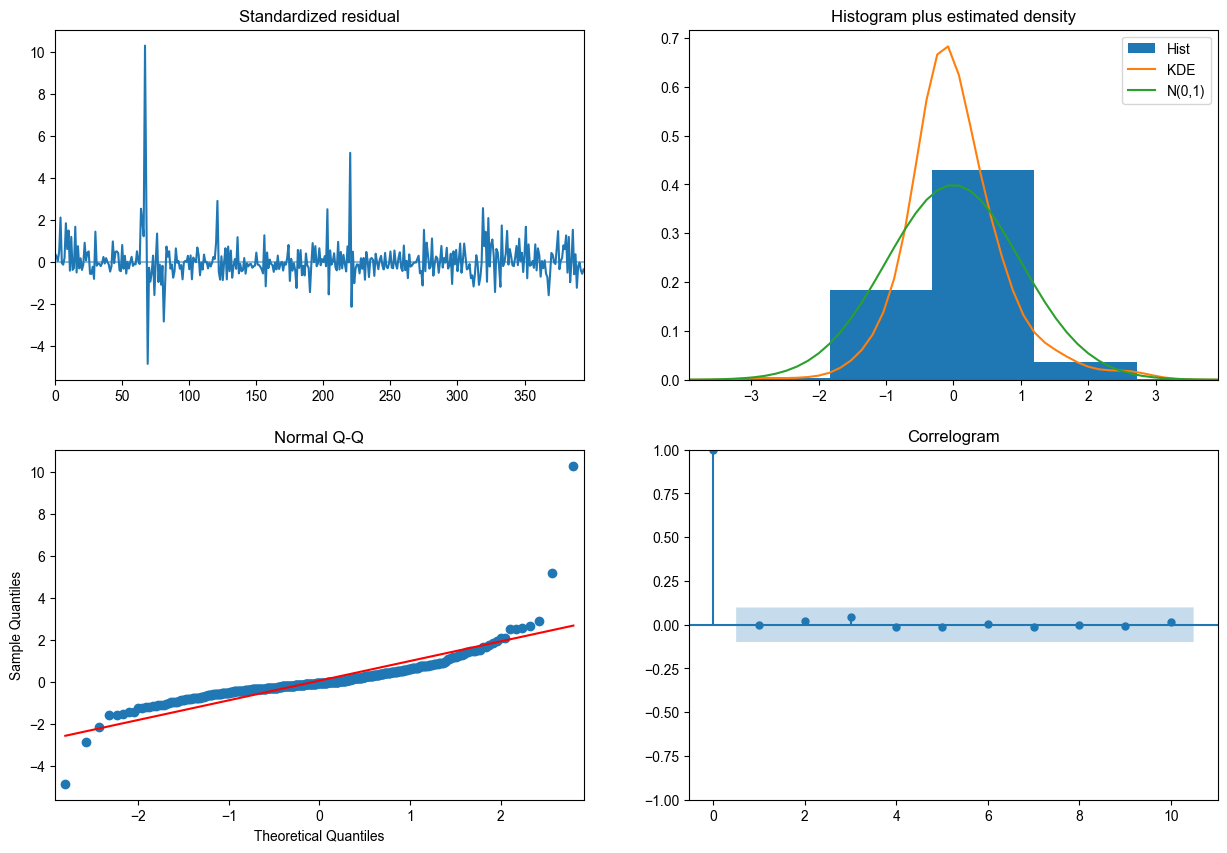

In [14]:
# 殘差診斷(原本 Auto-ARIMA 模型的)，這個只是拿來分析用，實際跑的是拿 ARIMA 的
auto_model.plot_diagnostics(figsize = (15, 10))
plt.show()

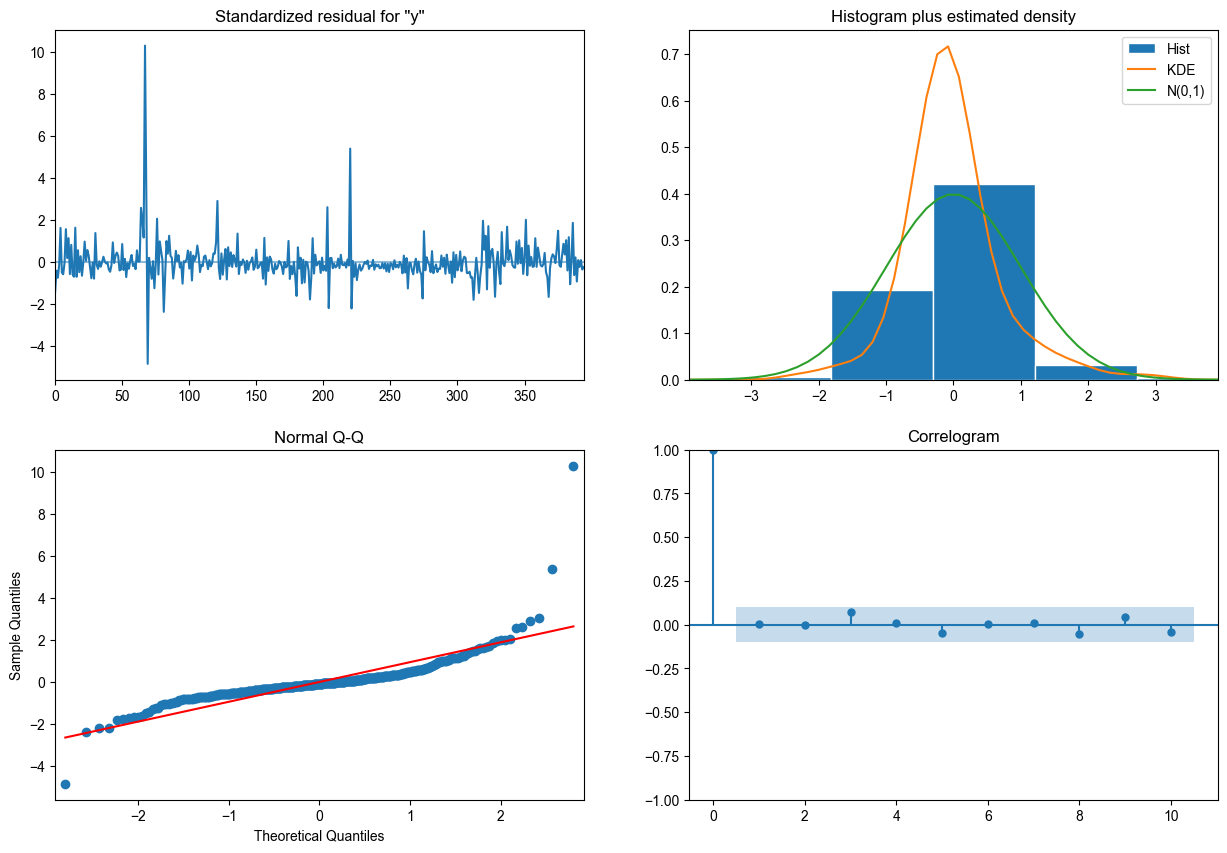

In [15]:
# 殘差診斷(原本 ARIMA 模型的)
model_summary_fit.plot_diagnostics(figsize = (15, 10))
plt.show()

## 白噪音檢定
藉由 Ljung-Box 定觀察 ARIMA 模型的殘差項是否為隨機變動，若檢定結果呈現白噪音(隨機)，則可以知道ARIMA模型的配適程度良好，便直接做預測；然而，若檢定結果呈現誤差項目並非白噪音，則需要用 `GARCH 模型找出誤差項中的變異數解釋變量`。

+ lb_stat : 這是 Ljung-Box 檢驗的檢驗統計量，用於檢查序列的自相關性，值越高表示序列具有較強的自相關性。
+ lb_pvalue : 這是對應於 Ljung-Box 統計量的 p 值，`用於檢驗零假設，即序列是白噪聲`，p 值小於 0.05（或選擇的顯著性水平）表示可以拒絕零假設，即序列可能具有顯著的自相關性，不是白噪聲。

In [16]:
lb_pvalue, white_noise_arima = arima.arima_acorr_ljungbox(arima_resid, training_window)

print('↓↓↓↓ Ljung-Box 檢驗結果 ↓↓↓↓') 
white_noise_arima

# Ljung-Box 檢驗
 H0: 誤差項為白噪音，資料是隨機的
 H1: 誤差項不是白噪音

誤差項 (P-value >= 0.05)，不能拒絕原假設(H0 成立)，殘差 "是" 白噪聲，代表殘差項目中沒有其他解釋變量可以提取，可直接使用 ARIMA 檢驗，理論上就可以停了
↓↓↓↓ Ljung-Box 檢驗結果 ↓↓↓↓


,lb_stat,lb_pvalue
14,5.474218,0.978058


## ARCH Effect 檢定

In [17]:
arch_test_result = arima.arima_het_arch(arima_resid, training_window)

# ARCH Effect 檢定
 H0: 資料中不存在 ARCH 效應
 H1: 資料中存在 ARCH 效應

殘差的方差 (P-value > 0.05)，不能拒原假設(H0 成立)，不存在顯著的 ARCH 效應，理論上就可以停了
↓↓↓↓ ARCH 檢驗結果 ↓↓↓↓
ARCH 檢驗統計量: 21.99769332331505
p 值: 0.07866178044771394
F 統計量: 1.6018909720870493
F 統計量的 p 值: 0.07618205948496509


# 顯示預測圖表

# 顯示預測圖表


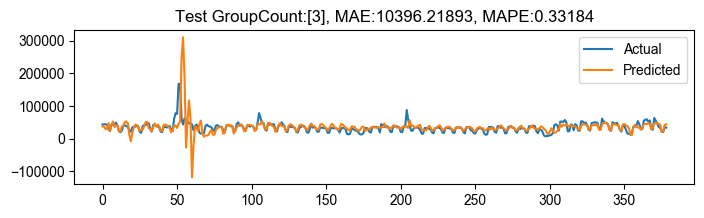

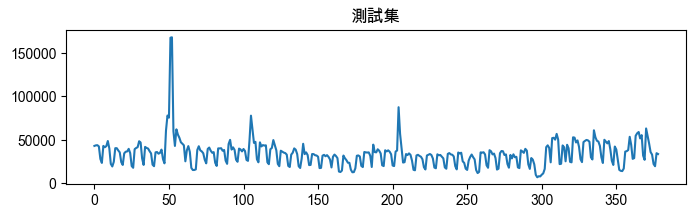

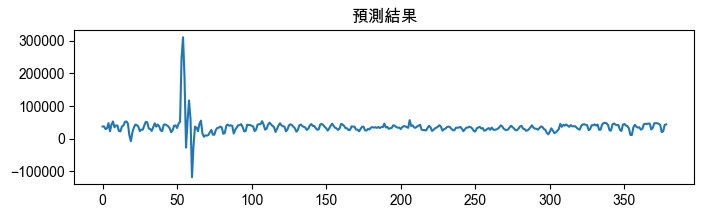

In [18]:
title = f'Test {fieldName}:{predict_types}, MAE:{round(mae, 5)}, MAPE:{round(mape, 5)}'

arima.show_predict_chart(
    eval_df,   
    actual = test_acts,
    predict = predictions,
    title = title
)

plt.figure(figsize=(8, 2))
plt.plot(test_acts, label='Actual')
plt.title('測試集')
plt.show()

plt.figure(figsize=(8, 2))
plt.plot(predictions)
plt.title('預測結果')
plt.show()

# 儲存結果

In [19]:
arima.save_json_file(
    result_file_name, 
    label = fieldName,
    predicteds = predict_types,
    best_p = best_p,
    best_d = best_d,
    best_q = best_q,
    best_aic = best_aic,
    best_ar_pvalue = best_ar_pvalue,
    best_ma_pvalue = best_ma_pvalue,
    mae_test = mae,
    mape_test = mape, 
    mse_test = mse,
    rmse_test = rmse,
    r_square_test = r_square,
    lb_pvalue = lb_pvalue,
    arch_pvalue = arch_test_result[1]
) 

# 儲存評估結果到 JSON 檔案
{'label': 'GroupCount', 'predicteds': [3], 'arima_p': 10, 'arima_d': 0, 'arima_q': 10, 'aic': 8389.526195987411, 'test_mae': 10396.21893, 'test_mape': 0.33184, 'test_mse': 606693962.92458, 'test_rmse': 24631.15838, 'test_r_square': -1.49298, 'ar_pvalue': '0.2560427868', 'ma_pvalue': '0.0000000000', 'lb_pvalue': 0.978057962234581, 'arch_pvalue': 0.07866178044771394}
儲存評估結果到 ARIMA/_Model/GroupCount_data3.result.json
